# ML Group Project - Movie Recommendation Systems PART 1
### By Jayesh Zambre, Soumya Mohan, Natalie Greener, Ryan Schmitzer, Agustin Arcos


## Import Packages and Files

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
#reading tag ratings dataset
genomescores = pd.read_csv("genome-scores.csv", header = 0)
genometags = pd.read_csv("genome-tags.csv", header = 0)

In [4]:
#reading movie, tags, links and and ratings
links = pd.read_csv("links.csv", header = 0)
movies = pd.read_csv("movies.csv", header = 0)
ratings = pd.read_csv("ratings.csv", header = 0)
tags = pd.read_csv("tags.csv", header = 0)

In [5]:
#reading imdb dataset
namebasics = pd.read_csv("name-basics.csv", header = 0)
titlebasics = pd.read_csv("title-basics.csv", header = 0)
titlecrew = pd.read_csv("title-crew.csv", header = 0)
titleratings = pd.read_csv("title-ratings.csv", header = 0)

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_53304/2852428451.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titlebasics = pd.read_csv("title-basics.csv", header = 0)


In [6]:
tags.movieId.nunique()

45251

In [7]:
#convert to lower case
tags['tag'] = tags['tag'].str.lower()
# Group the dataset by movieId and tag, then count occurrences
tag_counts = tags.groupby(["movieId", "tag"], sort=False)["tag"].count().reset_index(name="tag_count")

# Get the top 5 tags for each movieId
top_tags_per_movie = (
    tag_counts
    .sort_values(by=["movieId", "tag_count"], ascending=[True, False])
    .groupby('movieId', sort=False)
    .head(5)
)

# Concatenate the top 5 tags into a single string separated by commas
top_tags_per_movie['top_tags'] = top_tags_per_movie.groupby('movieId', sort=False)['tag'].transform(lambda x: ', '.join(x))

# Drop unnecessary columns
top_tags_per_movie.drop(['tag', 'tag_count'], axis=1, inplace=True)

# Drop duplicates and reset index
top_tags_per_movie.drop_duplicates(inplace=True)
top_tags_per_movie.reset_index(drop=True, inplace=True)

# Data Cleaning 

## MovieLens Data

In [10]:
genomescores.movieId.nunique()

13816

In [11]:
# merge genomescores & genometags on 'tagID'
gst = pd.merge(genomescores, genometags, on='tagId')
gst

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,2,1,0.04125,007
2,3,1,0.04675,007
3,4,1,0.03425,007
4,5,1,0.04300,007
...,...,...,...,...
15584443,205072,1128,0.09100,zombies
15584444,205076,1128,0.02350,zombies
15584445,205383,1128,0.03925,zombies
15584446,205425,1128,0.02850,zombies


In [12]:
# getting only those genome scores with relevance of atleast 0.9
gst.shape
gst=gst[gst.relevance>0.9].sort_values(by="movieId")

In [13]:
#gst concatenate tags
gst_group = gst.groupby('movieId')['tag'].agg(lambda x: ', '.join(x)).reset_index()

In [14]:
gst=gst_group.copy()
gst

,movieId,tag
0,1,"imdb top 250, kids, story, kids and family, co..."
1,2,"special effects, adventure, fantasy, children,..."
2,3,"good sequel, sequel, sequels"
3,4,women
4,5,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...
12356,202934,assassin
12357,203513,original
12358,204692,"original, weird"
12359,204698,"visually appealing, social commentary"


In [15]:
#merging movies(left) and genome scores and tags(right)
gstm = pd.merge(left=movies,right=gst,on='movieId',how="left")
gstm

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"imdb top 250, kids, story, kids and family, co..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"special effects, adventure, fantasy, children,..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"good sequel, sequel, sequels"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,women
4,5,Father of the Bride Part II (1995),Comedy,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...,...,...
62418,209157,We (2018),Drama,NaN
62419,209159,Window of the Soul (2001),Documentary,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,NaN
62421,209169,A Girl Thing (2001),(no genres listed),NaN


In [16]:
#clean up genres syntax from the movies dataset
#gst genres - , and space in ML dataset
gstm['genres'] = gstm['genres'].apply(lambda x: ','.join(x.split('|')))
gstm

,movieId,title,genres,tag
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","good sequel, sequel, sequels"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance",women
4,5,Father of the Bride Part II (1995),Comedy,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...,...,...
62418,209157,We (2018),Drama,NaN
62419,209159,Window of the Soul (2001),Documentary,NaN
62420,209163,Bad Poems (2018),"Comedy,Drama",NaN
62421,209169,A Girl Thing (2001),(no genres listed),NaN


In [17]:
#checking null values
gstm.tag.isna().sum()

50062

In [18]:
# cleaning up title names
# Extracts the title name and year from the 'title' column and stores them in separate columns.
# Converts the extracted year to numeric format, handling any conversion errors, and uses a nullable integer type.
# Removes the original 'title' column, keeping only the cleaned 'title_name' and 'year' columns.

gstm[['title_name', 'year']] = gstm['title'].str.extract(r'(.*) \((\d+)\)')
gstm['year'] = pd.to_numeric(gstm['year'], errors='coerce').astype('Int64') 
gstm = gstm.drop('title', axis=1)
gstm

,movieId,genres,tag,title_name,year
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995
...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018
62419,209159,Documentary,NaN,Window of the Soul,2001
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018
62421,209169,(no genres listed),NaN,A Girl Thing,2001


In [19]:
ratings_df = ratings.groupby(['movieId'])['rating'].mean().reset_index()
ratings_df

,movieId,rating
0,1,3.893708
1,2,3.251527
2,3,3.142028
3,4,2.853547
4,5,3.058434
...,...,...
59042,209157,1.500000
59043,209159,3.000000
59044,209163,4.500000
59045,209169,3.000000


In [20]:
# merge gstm & ratings_df on 'movieId' using a left merge
gstmr = pd.merge(gstm, ratings_df, on='movieId', how="left")
gstmr
# Rename the 'rating' column to 'rating_movie'
gstmr.rename(columns={'rating': 'rating_movie'}, inplace=True)
gstmr.rename(columns={'genres': 'genre_movie'}, inplace=True)
gstmr

,movieId,genre_movie,tag,title_name,year,rating_movie
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434
...,...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018,1.500000
62419,209159,Documentary,NaN,Window of the Soul,2001,3.000000
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000
62421,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000


In [21]:
gstmr.rating_movie.isna().sum()

3376

In [22]:
# import 'links.csv' and drop the 'tmdbId' column
links = pd.read_csv("links.csv", header = 0)
links = links.drop('tmdbId', axis=1)

In [23]:
# merge gstmr & links on 'movieID'
gstmrl = pd.merge(gstmr, links, on='movieId')
gstmrl

,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041
...,...,...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018,1.500000,6671244
62419,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366
62421,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603


In [24]:
titlebasics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [25]:
# Filters the DataFrame to keep only entries with the titleType 'movie'.
# Removes the prefix 'tt' from the 'tconst' column values, typically representing unique identifiers for titles.
# Strips leading zeros from the 'tconst' column values if present.
# Returns the modified DataFrame 'titlebasics'.

titlebasics = titlebasics[titlebasics['titleType'] == 'movie']
titlebasics['tconst'] = titlebasics['tconst'].str.replace('tt', '')
titlebasics['tconst'] = titlebasics['tconst'].apply(lambda x: x.lstrip('0'))
titlebasics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,9,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
10588573,9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
10588600,9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
10588612,9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
10588622,9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


In [26]:
# Converts the 'year' column in the 'gstmrl' DataFrame to string type.
# Converts the 'startYear' column in the 'titlebasics' DataFrame to string type.
# Converts the 'imdbId' column in the 'gstmrl' DataFrame to string type.
# Merges the 'titlebasics' and 'gstmrl' DataFrames based on the 'tconst' and 'imdbId' columns, retaining all rows from 'gstmrl'.
# Renames the 'genres' column in the merged DataFrame to 'genre_imdb'.
# Returns the merged DataFrame 'bruh'.

gstmrl['year'] = gstmrl['year'].astype(str)
titlebasics['startYear'] = titlebasics['startYear'].astype(str)
gstmrl['imdbId'] = gstmrl['imdbId'].astype(str)
bruh = pd.merge(titlebasics, gstmrl, left_on='tconst', right_on='imdbId', how='right')
bruh.rename(columns={'genres': 'genre_imdb'}, inplace=True)
bruh

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genre_imdb,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId
0,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709
1,113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family",2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497
2,113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance",3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228
3,114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance",4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885
4,113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance",5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,6671244,movie,Wij,Wij,0,2018,\N,100,Drama,209157,Drama,NaN,We,2018,1.500000,6671244
62419,297986,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986
62420,6755366,movie,Bad Poems,Rossz versek,0,2018,\N,97,"Comedy,Drama",209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366
62421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603


## IMDB Data

In [29]:
# merge namebasics & titlecrew dataset together by a left merge on 'nconst' and right merge on 'directors'
directors = pd.merge(namebasics, titlecrew, left_on='nconst', right_on='directors')
directors

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,directors,writers
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038468,nm0000005,"nm0102602,nm0340471,nm0000005"
1,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038675,nm0000005,"nm0000005,nm0279027"
2,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0039834,nm0000005,"nm0000005,nm0845496"
3,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040418,nm0000005,"nm0000005,nm0529508"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040622,nm0000005,nm0249647
...,...,...,...,...,...,...,...,...,...
4887230,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18361688,nm9993694,"nm9993694,nm0592792,nm13445917"
4887231,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18687502,nm9993694,"nm11789966,nm9993694,nm13445916"
4887232,nm9993696,Ibrahim-Aloduley,\N,\N,"director,editor",tt8744160,tt8744160,nm9993696,\N
4887233,nm9993708,Eli Bevins,\N,\N,"producer,director,writer","tt14508814,tt11702702,tt11772904,tt11772858",tt9046122,nm9993708,\N


In [31]:
# merge the directors & titleratings dataset together on 'tconst'
imdb = pd.merge(directors, titleratings, on='tconst')
imdb

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,directors,writers,averageRating,numVotes
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038468,nm0000005,"nm0102602,nm0340471,nm0000005",6.6,1677
1,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038675,nm0000005,"nm0000005,nm0279027",6.4,3464
2,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0039834,nm0000005,"nm0000005,nm0845496",6.4,2173
3,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040418,nm0000005,"nm0000005,nm0529508",6.6,2731
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040622,nm0000005,nm0249647,6.4,1490
...,...,...,...,...,...,...,...,...,...,...,...
995546,nm9993123,Rajdeep Dhanuka,\N,\N,"director,writer,assistant_director","tt8866550,tt10199974,tt8866396,tt8742880",tt8742880,nm9993123,"nm9993124,nm9993123",8.9,13
995547,nm9993154,Carlos Milite,\N,\N,"director,writer,visual_effects","tt26733150,tt12275324,tt10470278,tt8742964",tt12275324,nm9993154,"nm11559516,nm9993154",5.9,17
995548,nm9993205,João Brás,\N,\N,"director,editor,writer","tt15192934,tt29425971,tt29142641,tt22614348",tt10212264,nm9993205,"nm9993205,nm10636794",6.7,14
995549,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18361688,nm9993694,"nm9993694,nm0592792,nm13445917",8.8,35


# Final Merge

In [32]:
# Removes the prefix 'tt' from the 'tconst' column values in the 'imdb' DataFrame.
# Strips leading zeros from the 'tconst' column values in the 'imdb' DataFrame.
# Merges the 'bruh' and 'imdb' DataFrames based on the 'tconst' column, keeping all rows from 'bruh'.
# Returns the merged DataFrame 'esketit'.

imdb['tconst'] = imdb['tconst'].str.replace('tt', '')
imdb['tconst'] = imdb['tconst'].apply(lambda x: x.lstrip('0'))
esketit = pd.merge(bruh, imdb, on='tconst',how="left")
esketit

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genre_imdb,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,directors,writers,averageRating,numVotes
0,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709,nm0005124,John Lasseter,1957,\N,"producer,writer,director","tt0120363,tt0114709,tt0317219,tt0120623",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,1060309.0
1,113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family",2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497,nm0002653,Joe Johnston,1950,\N,"director,visual_effects,producer","tt0082971,tt0102803,tt0132477,tt0458339",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,373789.0
2,113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance",3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228,nm0222043,Howard Deutch,1950,\N,"director,producer,miscellaneous","tt17543592,tt1046163,tt0091790,tt0094006",nm0222043,nm0425756,6.6,29575.0
3,114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance",4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885,nm0001845,Forest Whitaker,1961,\N,"actor,producer,director","tt0455590,tt0185183,tt1825683,tt1327773",nm0001845,"nm0573334,nm0060103",6.0,12054.0
4,113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance",5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041,nm0796124,Charles Shyer,\N,\N,"writer,producer,assistant_director","tt0120783,tt0081375,tt0101862,tt0375173",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,41396.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,6671244,movie,Wij,Wij,0,2018,\N,100,Drama,209157,Drama,NaN,We,2018,1.500000,6671244,nm1415482,Rene Eller,\N,\N,"director,writer,producer",tt6671244,nm1415482,"nm1415482,nm1818234",5.6,3343.0
62419,297986,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62420,6755366,movie,Bad Poems,Rossz versek,0,2018,\N,97,"Comedy,Drama",209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366,nm2520391,Gábor Reisz,1980,\N,"director,writer,composer","tt3496334,tt27788968,tt6755366,tt2351598",nm2520391,nm2520391,7.5,2814.0
62421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
esketit.shape

(62423, 26)

In [34]:
# drop columns ('endYear', 'isAdult', 'originalTitle', 'titleType', 'startYear', 'nconst', 'birthYear', 'deathYear', 'writers')
yeet = esketit.drop(['endYear', 'isAdult', 'originalTitle', 'titleType', 'startYear', 'nconst', 'birthYear', 'deathYear', 'writers'], axis=1)
yeet.shape

(62423, 17)

In [35]:
df=yeet.copy()

In [36]:
# Check for missing values (NaN) in each column of the DataFrame
df.isna().sum()

tconst                9456
primaryTitle          9456
runtimeMinutes        9456
genre_imdb            9456
movieId                  0
genre_movie              0
tag                  50062
title_name             416
year                     0
rating_movie          3376
imdbId                   0
primaryName          14046
primaryProfession    14046
knownForTitles       14046
directors            14046
averageRating        14046
numVotes             14046
dtype: int64

In [37]:
# Replace "(no genres listed)" with NaN in 'genre_movies'
df['genre_movie'] = df['genre_movie'].replace('(no genres listed)', np.nan)

In [38]:
df['genre_movie'].isna().sum()

5062

In [39]:
# Function to combine and remove duplicates
def combine_genres(row):
    # Split and combine genres from both columns, handling NaN values
    imdb_genres = row['genre_imdb'].split(', ') if isinstance(row['genre_imdb'], str) else []
    movies_genres = row['genre_movie'].split(', ') if isinstance(row['genre_movie'], str) else []
    
    all_genres = imdb_genres + movies_genres
    
    # Remove duplicates using a set and maintain order
    unique_genres = list(dict.fromkeys(all_genres))
    
    return ', '.join(unique_genres)

# Apply the function to create a new 'unique_genres' column as a string
df['unique_genres'] = df.apply(combine_genres, axis=1)

In [40]:
# Convert 'unique_genres' to a set and then back to a string
df['unique_genres'] = df['unique_genres'].apply(lambda x: ', '.join(set(x.split(','))))

In [42]:
df.shape

(62423, 18)

In [43]:
df2=df[df["unique_genres"]!=""]

In [44]:
df2.shape

(61056, 18)

In [46]:
# Drop the original genre columns if needed
df2.drop(['genre_imdb', 'genre_movie'], axis=1, inplace=True)

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_53304/155365076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['genre_imdb', 'genre_movie'], axis=1, inplace=True)


In [47]:
df2.shape

(61056, 16)

In [48]:
from collections import Counter

# Define a function to clean and return unique genres from a string
def get_unique_genres(genre_string):
    # Split by comma, strip whitespaces, remove empty strings, and ensure uniqueness
    genres = set(genre.strip() for genre in genre_string.split(',') if genre.strip())
    # Convert back to a sorted list and join into a string for consistency
    return ', '.join(sorted(genres))

# Apply the function to each entry in the 'unique_genres' column
# Ensure the 'unique_genres' column is a string type to avoid errors during split
df2['unique_genres'] = df2['unique_genres'].astype(str)
df2['cleaned_unique_genres'] = df2['unique_genres'].apply(get_unique_genres)

# Create a counter for the cleaned genres to check the occurrence of each genre
cleaned_genre_counts = Counter()
# Use a list comprehension to split and strip genres for accurate counting
[cleaned_genre_counts.update(genre.strip() for genre in genres.split(',')) for genres in df2['cleaned_unique_genres']]

# Now, we can display the most common genres to ensure there are no duplicates
print(cleaned_genre_counts.most_common(10))

# Drop the original 'unique_genres' column as it is no longer needed
df2 = df2.drop('unique_genres', axis=1)

# The dataframe df2 now contains the cleaned and unique genres in the 'cleaned_unique_genres' column
# and the 'unique_genres' column has been removed.b

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_53304/512743614.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['unique_genres'] = df2['unique_genres'].astype(str)
/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_53304/512743614.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cleaned_unique_genres'] = df2['unique_genres'].apply(get_unique_genres)


[('Drama', 32566), ('Comedy', 20177), ('Romance', 11225), ('Thriller', 10652), ('Action', 9571), ('Crime', 8900), ('Horror', 6940), ('Adventure', 6361), ('Documentary', 6115), ('Mystery', 4981)]


In [49]:
df2.isna().sum()

tconst                    8089
primaryTitle              8089
runtimeMinutes            8089
movieId                      0
tag                      48705
title_name                 346
year                         0
rating_movie              3323
imdbId                       0
primaryName              12679
primaryProfession        12679
knownForTitles           12679
directors                12679
averageRating            12679
numVotes                 12679
cleaned_unique_genres        0
dtype: int64

In [50]:
# Merge two DataFrames, df2 and top_tags_per_movie, based on the 'movieId' column
df3=pd.merge(df2,top_tags_per_movie,on="movieId",how="left")

In [51]:
df3.shape

(61056, 17)

In [52]:
df3.isna().sum()

tconst                    8089
primaryTitle              8089
runtimeMinutes            8089
movieId                      0
tag                      48705
title_name                 346
year                         0
rating_movie              3323
imdbId                       0
primaryName              12679
primaryProfession        12679
knownForTitles           12679
directors                12679
averageRating            12679
numVotes                 12679
cleaned_unique_genres        0
top_tags                 16291
dtype: int64

In [54]:
df4=df3[["title_name","rating_movie","primaryName","primaryProfession","averageRating","top_tags","cleaned_unique_genres","numVotes","year","movieId"]]

In [55]:
df4.dropna(inplace=True)

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_53304/1595090722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.dropna(inplace=True)


In [56]:
df4.shape

(33315, 10)

In [58]:
df4.sort_values("year",ascending=False).head(10)

,title_name,rating_movie,primaryName,primaryProfession,averageRating,top_tags,cleaned_unique_genres,numVotes,year,movieId
57952,Little,2.304348,Tina Gordon,"writer,director,producer",5.5,"being a kid again, bitch, body swap, child as ...","Comedy, Fantasy, Romance",14525.0,2019,200326
58409,The Lighthouse,3.669118,Robert Eggers,"production_designer,director,writer",7.4,"willem dafoe, great acting, black and white, l...","Drama, Fantasy, Horror",251335.0,2019,201340
58420,Long Shot,3.304147,Jonathan Levine,"producer,director,writer",6.8,"comedy, politics, jim's list, reviewed, theater","Comedy, Romance",120894.0,2019,201368
33256,Shazam!,3.397516,David F. Sandberg,"director,writer,producer",7.0,"superhero, funny, magic, dc comics, superhuman...","Action, Adventure, Comedy, Fantasy, Sci-Fi",381983.0,2019,143345
58456,Knock Down the House,3.953488,Rachel Lears,"cinematographer,producer,director",7.4,"documentary, politics, political, women, alexa...",Documentary,12945.0,2019,201444
58467,Creep Nation,3.333333,John Geddes,"producer,sound_department,director",4.4,"air bnb, murder, revenge, surveillance","Horror, Thriller",250.0,2019,201480
58490,Steel Country,2.277778,Simon Fellows,"director,writer,producer",6.2,"murder, mystery, thriller, andrew scott, child...","Mystery, Thriller",5269.0,2019,201538
58496,Men in Black: International,2.886719,F. Gary Gray,"director,producer,actor",5.6,"aliens, humorous, tessa thompson, matt hollowa...","Action, Adventure, Comedy, Sci-Fi",145728.0,2019,201586
58497,Toy Story 4,3.624444,Josh Cooley,"actor,writer,director",7.7,"pixar, sequel, touching, friendship, bittersweet","Adventure, Animation, Children, Comedy",277312.0,2019,201588
58499,Brightburn,3.062992,David Yarovesky,"director,editor,producer",6.1,"predictable, anti-hero, supernatural, jump sca...","Drama, Horror, Mystery, Sci-Fi, Thriller",106826.0,2019,201594


# EDA

In [59]:
import seaborn as sns

df_EDA = df2.copy()

# Convert 'runtimeMinutes' and 'year' to integers if they are not already
df_EDA['runtimeMinutes'] = pd.to_numeric(df_EDA['runtimeMinutes'], errors='coerce')
df_EDA['year'] = pd.to_numeric(df_EDA['year'], errors='coerce')

# Drop any rows that might have had invalid data after conversion
df_EDA = df_EDA.dropna(subset=['runtimeMinutes', 'year'])

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

In [60]:
# Numeric types:
summary_numeric = df.describe(include=[np.number])
summary_numeric

,movieId,rating_movie,averageRating,numVotes
count,62423.000000,59047.000000,48377.000000,4.837700e+04
mean,122220.387646,3.071374,6.153778,1.847278e+04
std,63264.744844,0.739840,1.117429,8.292175e+04
min,1.000000,0.500000,1.000000,6.000000e+00
25%,82146.500000,2.687500,5.500000,4.860000e+02
50%,138022.000000,3.150000,6.300000,1.449000e+03
75%,173222.000000,3.500000,6.900000,5.639000e+03
max,209171.000000,5.000000,9.300000,2.863284e+06


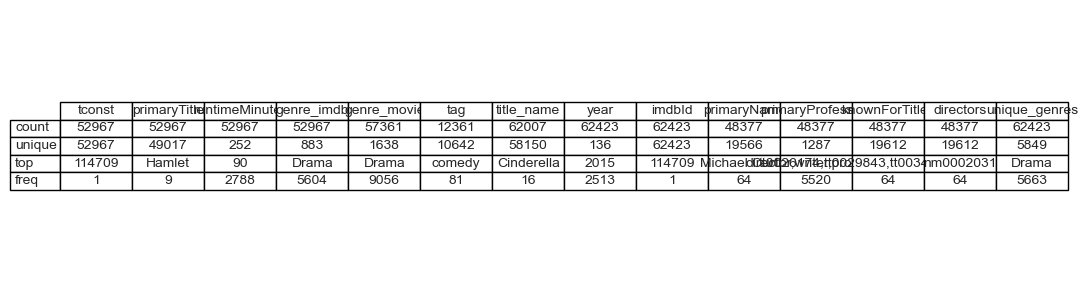

In [61]:
# Categorical objects:
summary_categorical = df.describe(include=[object])
summary_categorical

# Create a figure with a suitable size to accommodate the table.
# Note that you may need to adjust the size based on your actual DataFrame.
fig, ax = plt.subplots(figsize=(12, 4))  # The figsize may need to be adjusted

# Hide the axes
ax.axis('off')

# Create the table and adjust the layout
table = ax.table(cellText=summary_categorical.values,
                 colLabels=summary_categorical.columns,
                 rowLabels=summary_categorical.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)  # You may need to adjust this size
table.scale(1.2, 1.2)  # You may need to adjust the scale

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

# Save the figure as an image
plt.savefig('summary_categorical_legible.png', bbox_inches='tight')
plt.show()

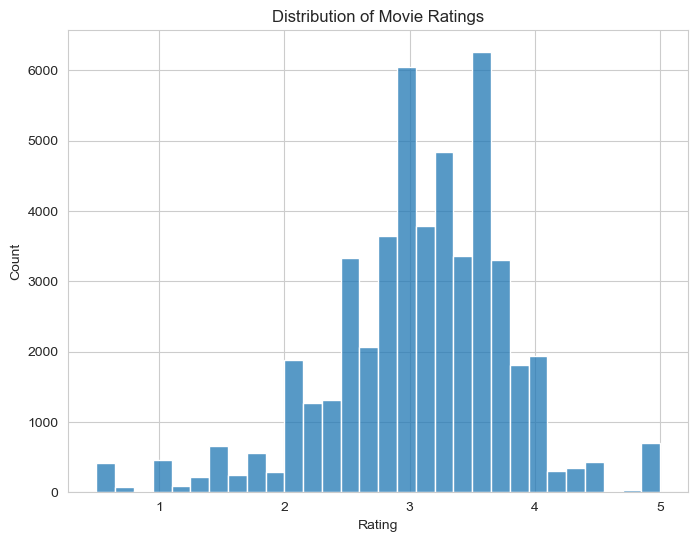

In [62]:
# Distribution of Movie Ratings
plt.figure(figsize=(8, 6))
sns.histplot(df_EDA['rating_movie'].dropna(), bins=30, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('distribution_of_movie_ratings.png')  # Saves in the current working directory
plt.show()

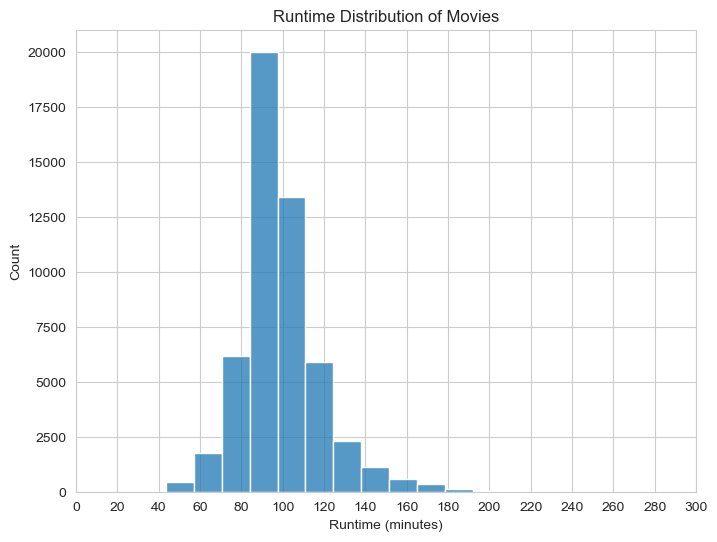

In [63]:
# Runtime Distribution of Movies
plt.figure(figsize=(8, 6))
sns.histplot(df_EDA[df_EDA['runtimeMinutes'] <= 300]['runtimeMinutes'].dropna(), bins=20, kde=False)
plt.title('Runtime Distribution of Movies')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Count')
plt.xticks(np.arange(0, 320, 20))
plt.xlim(0, 300)
plt.savefig('runtime_distribution_of_movies.png')  # Saves in the current working directory
plt.show()

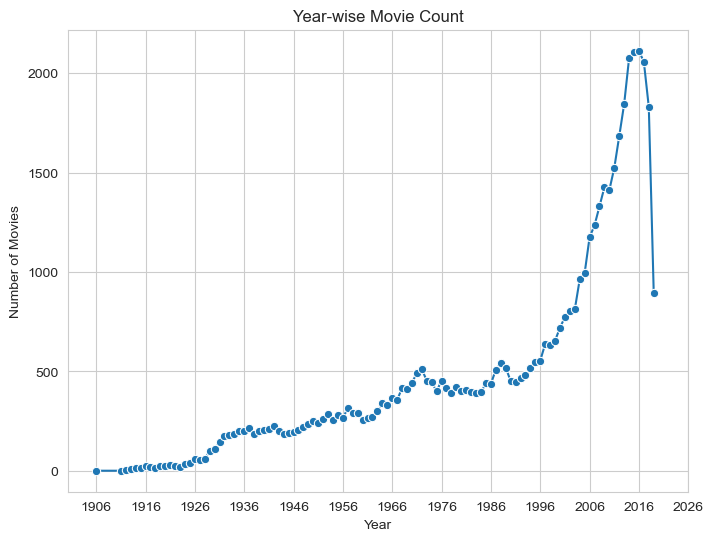

In [64]:
# Number of Movies for Each Year
df_EDA_year_count = df_EDA.groupby('year').size().reset_index(name='counts')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_EDA_year_count, x='year', y='counts', marker='o')
plt.title('Year-wise Movie Count')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
year_min, year_max = int(df_EDA['year'].min()), int(df_EDA['year'].max())
plt.xticks(np.arange(year_min, year_max + 10, 10))
plt.savefig('year_wise_movie_count.png')  # Saves in the current working directory
plt.show()

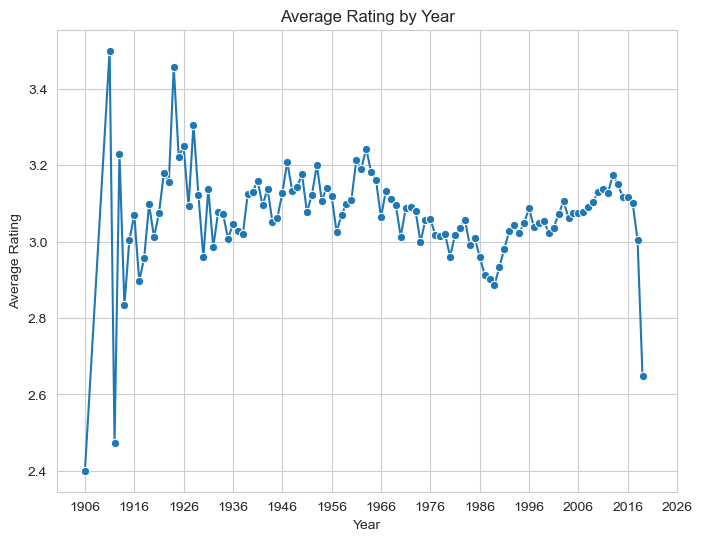

In [65]:
# Average Movie Rating by Year
df_EDA_avg_rating = df_EDA.groupby('year')['rating_movie'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_EDA_avg_rating, x='year', y='rating_movie', marker='o')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(np.arange(year_min, year_max + 10, 10))
plt.savefig('average_rating_by_year.png')  # Saves in the current working directory
plt.show()

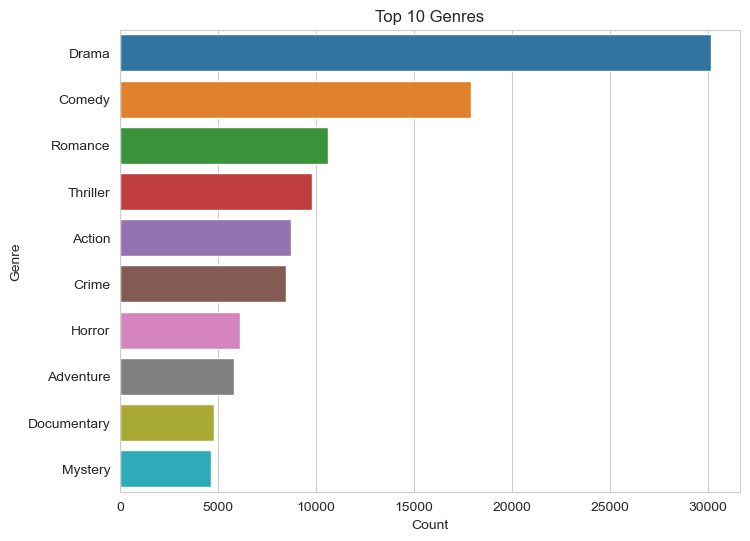

In [66]:
# Top Genres
def clean_and_count_genres(genre_list):
    # Strip spaces and split the genres
    genres = [genre.strip() for genre in genre_list.split(',')]
    # Update the counter with the cleaned list of genres
    genre_counts.update(genres)

# Initialize a Counter object for genre counts
genre_counts = Counter()

# Apply the function to each entry in 'cleaned_unique_genres'
df_EDA['cleaned_unique_genres'].apply(clean_and_count_genres)

# Now create a DataFrame from the genre counts for the top 10 genres
genre_df_EDA = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(data=genre_df_EDA, y='Genre', x='Count')
plt.title('Top 10 Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.savefig('top_10_genres.png')
plt.show()

# Content Based Filtering

In [67]:
df4.cleaned_unique_genres

0        Adventure, Animation, Children, Comedy, Fantasy
1           Adventure, Children, Comedy, Family, Fantasy
2                                        Comedy, Romance
3                                 Comedy, Drama, Romance
4                                Comedy, Family, Romance
                              ...                       
60978                            Action, Drama, Thriller
60989                 Adventure, Comedy, Family, Romance
60994                  Children, Comedy, Family, Fantasy
61015                                             Horror
61029                         Documentary, Drama, Family
Name: cleaned_unique_genres, Length: 33315, dtype: object

In [68]:
df4.reset_index(drop=True, inplace=True)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Combine relevant features into a single string - genre, top tags, director, imdb rating
df4['combined_features'] = (
    df4['cleaned_unique_genres'] + ' ' + df4['top_tags'] + ' ' + df4['primaryName'] + ' ' +
    df4["averageRating"].astype(str) + ' ' + df4["rating_movie"].astype(str) + ' ' + 
    df4["numVotes"].astype(str) + ' ' + df4["year"].astype(str)
)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the combined features
tfidf_matrix = tfidf_vectorizer.fit_transform(df4['combined_features'])

# Compute the cosine similarity between movies
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on similarity
def get_recommendations(title, cosine_sim_matrix, df4):
    idx = df4[df4['title_name'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  
    movie_indices = [i[0] for i in sim_scores]
    return df4['title_name'].iloc[movie_indices]

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_53304/3628059875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['combined_features'] = (


In [70]:
# Example usage
movie_title = "Jumanji"
recommendations = get_recommendations(movie_title, cosine_sim, df4)

print(f"Recommendations for {movie_title}:")
print(recommendations)

Recommendations for Jumanji:
1707                    Honey, I Shrunk the Kids
9131                                     Zathura
1739                              Rocketeer, The
12491           Black Waters of Echo's Pond, The
21847                            The Games Maker
15469    Under the Boardwalk: The Monopoly Story
30                                          Babe
31529        Neil Stryker and The Tyrant of Time
20477                          Not Safe for Work
17131                            Berkeley Square
Name: title_name, dtype: object


In [71]:
# Example usage
movie_title = "Doctor Strange"
recommendations = get_recommendations(movie_title, cosine_sim, df4)

print(f"Recommendations for {movie_title}:")
print(recommendations)

Recommendations for Doctor Strange:
14995                        Wreckers
16281                    Man of Steel
5507                 X2: X-Men United
10935                        Watchmen
19470                  Fantastic Four
15591     Conscientious Objector, The
14863                      Third Star
26894        Kubo and the Two Strings
27686    Rogue One: A Star Wars Story
19469                         Ant-Man
Name: title_name, dtype: object


# User Based Collaborative Filtering

In [74]:
# Extract the movie title and release year from the 'title' column using regular expressions
movies[['title_name', 'year']] = movies['title'].str.extract(r'(.*) \((\d+)\)')

# Merge ratings DataFrame with movies DataFrame to include movie titles and release years
rm=pd.merge(ratings, movies[['movieId', 'title_name', 'year']], on='movieId', how='left')
rm_19=rm[rm.year=="2019"]

# Filter movies released in the year 2019, to reduce complexity
rating_df = pd.DataFrame(rm_19)

In [77]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV, train_test_split
from surprise import KNNBasic
from surprise import accuracy

# Define the rating scale
reader = Reader(rating_scale=(0.5, 5))

# Load the dataset
dataset = Dataset.load_from_df(rating_df[['userId', 'movieId', 'rating']], reader)

# Split the dataset into train and test sets
trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

# Define the parameter grid to search
param_grid = {'k': [20, 30, 40], 'min_k': [1, 2, 3], 'sim_options': {'name': ['cosine', 'pearson']}}

# Use user-based collaborative filtering with KNN
model = KNNBasic

# Perform grid search
grid_search = GridSearchCV(model, param_grid, measures=['rmse'], cv=5)
grid_search.fit(dataset)

# Get the best model and its parameters
best_model = grid_search.best_estimator['rmse']
best_params = grid_search.best_params['rmse']

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computi

In [78]:
# Print the best parameters one below the other
print("Best parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best parameters:
k: 40
min_k: 3
sim_options: {'name': 'cosine', 'user_based': True}


In [79]:
from surprise import accuracy

# Train the best model on the full training set
best_model.fit(trainset)

# Make predictions on the train set
train_predictions = best_model.test(trainset.build_testset())

# Evaluate the model's performance on the train set
train_rmse = accuracy.rmse(train_predictions)
train_mae = accuracy.mae(train_predictions)

# Make predictions on the test set
test_predictions = best_model.test(testset)

# Evaluate the model's performance on the test set
test_rmse = accuracy.rmse(test_predictions)
test_mae = accuracy.mae(test_predictions)

# Print the results rounded to 2 decimal places
print(f"Train RMSE: {round(train_rmse, 2)}")
print(f"Train MAE: {round(train_mae, 2)}")
print(f"Test RMSE: {round(test_rmse, 2)}")
print(f"Test MAE: {round(test_mae, 2)}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9758
MAE:  0.7428
RMSE: 1.0710
MAE:  0.8175
Train RMSE: 0.98
Train MAE: 0.74
Test RMSE: 1.07
Test MAE: 0.82


In [80]:
# Function to get movie recommendations for a user
def get_recommendations(user_id, model, rating_df, n=10):
    items_seen_by_user = rating_df[rating_df['userId'] == user_id]['movieId'].tolist()
    items_to_predict = rating_df['movieId'].unique()
    items_to_predict = [item for item in items_to_predict if item not in items_seen_by_user]

    # Predict ratings for unseen items using the best model
    predictions = [model.predict(user_id, item) for item in items_to_predict]

    # Sort predictions by predicted rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N recommendations
    top_n = predictions[:n]

    # Extract movie IDs from recommendations
    recommended_movie_ids = [int(pred.iid) for pred in top_n]

    # Get the details of recommended movies from the original DataFrame
    recommended_movies = rating_df[rating_df['movieId'].isin(recommended_movie_ids)][['movieId', 'title_name']].drop_duplicates()

    return recommended_movies

In [81]:
# Example usage
user_id_to_recommend = 4
recommendations = get_recommendations(user_id_to_recommend, best_model, rating_df, n=10)

print(f"Top 10 movie recommendations for User {user_id_to_recommend}:")
print(recommendations)

Top 10 movie recommendations for User 4:
         movieId               title_name
23522     202439                 Parasite
23524     204698                    Joker
54639     201588              Toy Story 4
63088     197879                Apollo 11
437621    208939                    Klaus
1635498   207077  Roger Waters: Us + Them
2939461   199968                 Piranhas
2939501   206857             The Irishman
3030559   205327      Motherless Brooklyn
4919948   199095                Gully Boy


In [82]:
# Function to get both movie recommendations and already watched for a user
def get_recommendations(user_id, model, rating_df, n=10):
    items_seen_by_user = rating_df[rating_df['userId'] == user_id]['movieId'].tolist()
    items_to_predict = rating_df['movieId'].unique()
    items_to_predict = [item for item in items_to_predict if item not in items_seen_by_user]

    # Predict ratings for unseen items using the best model
    predictions = [model.predict(user_id, item) for item in items_to_predict]

    # Sort predictions by predicted rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get top N recommendations
    top_n = predictions[:n]

    # Extract movie IDs from recommendations
    recommended_movie_ids = [int(pred.iid) for pred in top_n]

    # Get the details of recommended movies from the original DataFrame
    recommended_movies = rating_df[rating_df['movieId'].isin(recommended_movie_ids)][['movieId', 'title_name']].drop_duplicates()

    # Print recommended movie names one below the other
    print(f"Top {n} movie recommendations for User {user_id}:")
    print("\n".join(recommended_movies['title_name'].tolist()))
    print("\n")

    # Print movies already watched by the user one below the other
    print(f"Movies already watched by User {user_id}:")
    watched_movies = rating_df[(rating_df['userId'] == user_id) & rating_df['movieId'].isin(items_seen_by_user)][['movieId', 'title_name']].drop_duplicates()
    print("\n".join(watched_movies['title_name'].tolist()))

# Example usage
user_id_to_recommend = 4
get_recommendations(user_id_to_recommend, best_model, rating_df, n=10)

Top 10 movie recommendations for User 4:
Parasite
Joker
Toy Story 4
Apollo 11
Klaus
Roger Waters: Us + Them
Piranhas
The Irishman
Motherless Brooklyn
Gully Boy


Movies already watched by User 4:
Avengers: Infinity War - Part II
John Wick: Chapter 3 – Parabellum
Pokémon: Detective Pikachu
Ford v. Ferrari
Fast & Furious Presents: Hobbs & Shaw
